In [1]:
import torch
from torch import nn
import torchvision as tv
import time
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
import GPUtil
GPUtil.showUtilization()

| ID | GPU | MEM |
------------------
|  0 | 24% | 13% |


In [3]:
import matplotlib.pyplot as plt # plotting
import numpy as np # linear algebra
import os # accessing directory structure
from PIL import Image
from collections import defaultdict
import pandas as pd

In [4]:
folder_train = "data/tsrd-train"
folder_test = "data/TSRD-Test"
dev = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
dev

device(type='cuda')

In [5]:
# ищем средний размер картинки
dimensions = defaultdict(int)
count = 0
avg_height = 0
avg_width = 0
for dirname, _, filenames in os.walk(folder_train):
    for filename in filenames:
        #print (dirname, filename)
        image = Image.open(f'{dirname}/{filename}')
        width = image.size[0] 
        height = image.size[1]
        avg_height += height
        avg_width += width
        dimenstion = f'{height}x{width}'
        dimensions[dimenstion] += 1
        count += 1
   
# средний размер картинки
avg_height = avg_height / count
avg_width = avg_width / count
print (f'Avg h = {avg_height}, avg_w = {avg_width}')

# ищем средний размер картинки
dimensions = defaultdict(int)
count = 0
avg_height = 0
avg_width = 0
for dirname, _, filenames in os.walk(folder_test):
    for filename in filenames:
        #print (dirname, filename)
        image = Image.open(f'{dirname}/{filename}')
        width = image.size[0] 
        height = image.size[1]
        avg_height += height
        avg_width += width
        dimenstion = f'{height}x{width}'
        dimensions[dimenstion] += 1
        count += 1
   
# средний размер картинки
avg_height = avg_height / count
avg_width = avg_width / count
print (f'Avg h = {avg_height}, avg_w = {avg_width}')

# проверяем resize
for dirname, _, filenames in os.walk(folder_train):
    for filename in filenames:
        image = Image.open(f'{dirname}/{filename}')
        image = image.resize((110, 110), Image.ANTIALIAS)
        print (image.size)
        break


Avg h = 140.85659472422063, avg_w = 152.13717026378896
Avg h = 110.09027081243731, avg_w = 115.88164493480441
(110, 110)


In [6]:
def my_normalize_tensor(t):
    for i in range(3):
        tmin = t[i].min()
        tmax = t[i].max()
        tsum  = t[i].sum()
        average = tsum/110/110
        #print (tmin, tmax, average)    
        diff = 0.5-average
        t[i] = t[i].add(diff)
    return t

def my_normalize_tensor_1layer(t):
    tmin = t.min()
    tmax = t.max()
    tsum  = t.sum()
    average = tsum/110/110
    diff = 0.5-average
    t = t.add(diff)
    return t

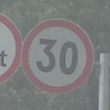

In [7]:
image = Image.open(f'{folder_train}/002_1_0002.png')
image = image.resize((110, 110), Image.ANTIALIAS)
transform_image = tv.transforms.Compose([ tv.transforms.ToTensor() ])
transform_toimage = tv.transforms.Compose([ tv.transforms.ToPILImage('RGB') ])

image_tensor = transform_image(image)
image_ntensor = my_normalize_tensor(image_tensor)
#image_ntensor = torch.nn.functional.normalize(image_tensor,10)
#image_ntensor = torch.renorm(image_tensor, 2, 2, 0)

image = transform_toimage(image_tensor)
imagen = transform_toimage(image_ntensor)

image

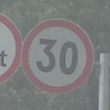

In [8]:
imagen

In [9]:
image_tensor[2]


tensor([[0.4694, 0.4733, 0.4733,  ..., 0.4615, 0.4537, 0.4458],
        [0.4694, 0.4694, 0.4655,  ..., 0.4655, 0.4576, 0.4498],
        [0.4655, 0.4615, 0.4537,  ..., 0.4772, 0.4733, 0.4615],
        ...,
        [0.4733, 0.4733, 0.4733,  ..., 0.5282, 0.4772, 0.4458],
        [0.4733, 0.4733, 0.4733,  ..., 0.5282, 0.4772, 0.4458],
        [0.4694, 0.4733, 0.4733,  ..., 0.5321, 0.4811, 0.4419]])

In [10]:
class CnTrafficSignsDataset(torch.utils.data.Dataset):
    def __init__(self, annotation_file, root_dir, transform=None):
        """
        Args:
            csv_file (string): Path to the csv file with annotations.
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.images = defaultdict(torch.tensor)
        self.root_dir = root_dir
        self.transform = transform  # нафик, тут все сделаю
        
        transform_image = tv.transforms.Compose([
            tv.transforms.Grayscale(1),
            #tv.transforms.ToTensor()
        ])    
        transform_image2 = tv.transforms.Compose([
            #tv.transforms.Grayscale(3),
            tv.transforms.ToTensor()
            
            #tv.transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
        ])
        
        # read all annotated files to memory
        self.annotation = pd.read_csv(annotation_file, sep=';', 
                  names=("fname","a1","a2","a3","a4","a5","a6","class_id","nan"))
        
        for filename in self.annotation["fname"]:
            image = Image.open(f'{root_dir}/{filename}')
            #image = image.resize((110, 110), Image.ANTIALIAS)
            image = image.resize((55, 55), Image.ANTIALIAS)
            image = transform_image(image)
            image_tensor = tv.transforms.functional.adjust_contrast(image,2)
            image_tensor = tv.transforms.functional.adjust_saturation(image,2)
            image_tensor = transform_image2(image)
            image_tensor = my_normalize_tensor_1layer(image_tensor)
            
            image_tensor = image_tensor.to(dev)
            
            self.images[filename] = image_tensor
        
        #self.landmarks_frame = pd.read_csv(csv_file)
        #self.root_dir = root_dir
        #self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        image_name = self.annotation.iloc[idx]["fname"]
        image_class = self.annotation.iloc[idx]["class_id"]
        #image_class = torch.tensor(image_class)
        image = self.images[image_name]
        
        sample = [ image, image_class ]
      
        if self.transform:
            sample = self.transform(sample)

        return sample

    def get_fname(self, idx):
        return self.annotation.iloc[idx]["fname"]
    
    def manual_normalize(self, img_min, img_max):
        # detect min and max
        if img_min == 999:
            img_max = -1000
            img_min = 1000
            # detect min and max
            for image in self.images:
                tensor_min = self.images[image].min()
                tensor_max = self.images[image].max()
                if tensor_min < img_min:
                    img_min = tensor_min
                if tensor_max > img_max:
                    img_max = tensor_max
                
        disperse = img_max - img_min
        
        for image in self.images:
            tmp_tensor = self.images[image]
            self.images[image] = (tmp_tensor - img_min) / disperse
            
        return img_min, img_max

In [11]:
train_dataset = CnTrafficSignsDataset("data/TSRD-Train Annotation/TsignRecgTrain4170Annotation.txt", 
                                      "data/tsrd-train")

In [12]:
test_dataset = CnTrafficSignsDataset("data/TSRD-Test Annotation/TsignRecgTest1994Annotation.txt", 
                                      "data/TSRD-Test")

In [13]:
# print (train_dataset[0][0][0])
# img_min, img_max = train_dataset.manual_normalize(999,999)
# print ("----------")
# print (train_dataset[0][0][0])
# print(img_min, img_max)
GPUtil.showUtilization()

| ID | GPU | MEM |
------------------
|  0 |  1% | 20% |


In [14]:
# смотрим 
def look_at(dataset):
    fig = plt.figure(figsize=(20,20));
    columns = 8;
    rows = 5;
    img_res = [[[0 for x in range(3)] for y in range(110)] for y in range(110)]
    for i in range(1, columns*rows +1):
        #img_xy = np.random.randint(len(train_set));
        img = dataset[i][0].cpu()
        fname = dataset.get_fname(i)
        fig.add_subplot(rows, columns, i)
        plt.title(f'{dataset[i][1]}_{fname}')
        plt.axis('off')
        #plt.imshow(img, cmap='gray')
        img0 = img[0,:,:].numpy()
        img1 = img[1,:,:].numpy()
        img2 = img[2,:,:].numpy()
#         for i in range(110):
#             for j in range(110):
        for i in range(55):
             for j in range(55):
                img_res[i][j][0] = img0[i][j]
                img_res[i][j][1] = img1[i][j]
                img_res[i][j][2] = img2[i][j]
        plt.imshow(img_res)
    plt.show()

IndexError: index 1 is out of bounds for dimension 0 with size 1

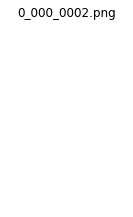

In [15]:
look_at(train_dataset)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

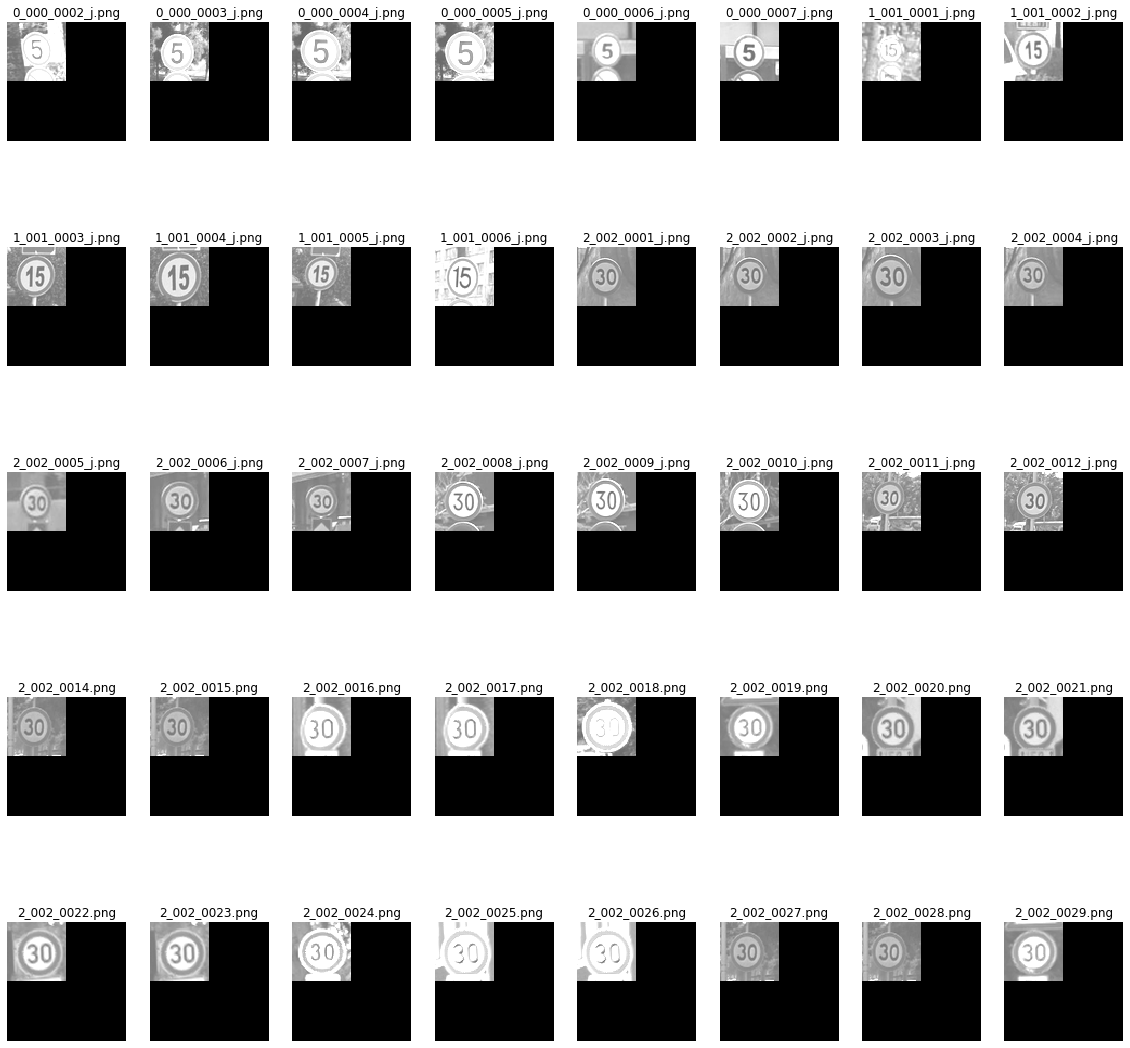

In [48]:
look_at(test_dataset)

In [16]:
BATCH_SIZE=100
train_iter = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_iter = torch.utils.data.DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=True)

In [17]:
GPUtil.showUtilization()

| ID | GPU | MEM |
------------------
|  0 |  1% | 20% |


In [35]:

# 55x55 test 71%
model = nn.Sequential(
    nn.Conv2d(1, 64, kernel_size=11),
    nn.ReLU(True),
    #nn.BatchNorm2d(80),
    nn.MaxPool2d(2, stride=2),
    nn.Conv2d(64, 128, kernel_size=3),
    nn.ReLU(True),
    
    nn.MaxPool2d(2, stride=2),

#     nn.Conv2d(128, 256, kernel_size=3),
#     nn.ReLU(True),
        
    nn.MaxPool2d(2, stride=2),
#    nn.MaxPool2d(2, stride=2),

    nn.BatchNorm2d(128),
    
    nn.Flatten(),
    #nn.AvgPool2d(3),
    nn.Linear(3200,512),
    nn.ReLU(True),
#     nn.Linear(1000,500),
#     nn.ReLU(True),
    nn.Linear(512, 58),
)

model = model.to(dev)

In [36]:
X,y = train_dataset[0]
#X = X.reshape(1, 3, 110, 110)
# X = X.reshape(1, 3, 55, 55)
X = X.reshape(1, 1, 55, 55)
for l in model:
    X = l(X)
    print("Layer {}. X shape: {}".format(l, X.shape))

Layer Conv2d(1, 64, kernel_size=(11, 11), stride=(1, 1)). X shape: torch.Size([1, 64, 45, 45])
Layer ReLU(inplace=True). X shape: torch.Size([1, 64, 45, 45])
Layer MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False). X shape: torch.Size([1, 64, 22, 22])
Layer Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1)). X shape: torch.Size([1, 128, 20, 20])
Layer ReLU(inplace=True). X shape: torch.Size([1, 128, 20, 20])
Layer MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False). X shape: torch.Size([1, 128, 10, 10])
Layer MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False). X shape: torch.Size([1, 128, 5, 5])
Layer BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True). X shape: torch.Size([1, 128, 5, 5])
Layer Flatten(). X shape: torch.Size([1, 3200])
Layer Linear(in_features=3200, out_features=512, bias=True). X shape: torch.Size([1, 512])
Layer ReLU(inplace=True). X shape: torch.Size([1, 512])
Layer 

In [37]:
def get_accuracy(data_iter, net, dev):
    acc_sum, n = torch.Tensor([0]).to(dev), 0
    for X, y in data_iter:
        X, y = X.to(dev), y.to(dev)
        acc_sum += (net(X).argmax(axis=1) == y).sum()
        n += y.shape[0]
    return acc_sum.item() / n

In [38]:
def train(net, train_iter, test_iter, trainer, num_epochs, dev):
    loss = nn.CrossEntropyLoss(reduction='sum')
    #loss = nn.CrossEntropyLoss()
    for epoch in range(num_epochs):
        train_l_sum, train_acc_sum, n, start = 0.0, 0.0, 0, time.time()
        for X, y in train_iter:
            trainer.zero_grad()
            y = y.to(dev)
            y_hat = net(X)
            l = loss(y_hat, y)
            l.backward()
            trainer.step()
            train_l_sum += l.item()
            train_acc_sum += (y_hat.argmax(axis=1) == y).sum().item()
            n += y.shape[0]
        test_acc = get_accuracy(test_iter, net, dev)
        #test_acc = 0
        print('epoch %d, loss %.4f, train acc %.3f, test acc %.3f, '
              'time %.1f sec'
              % (epoch + 1, train_l_sum / n, train_acc_sum / n, test_acc,
                 time.time() - start))

In [39]:
lr, num_epochs = 0.001, 50
#trainer = torch.optim.SGD(model.parameters(), lr=lr)
trainer = torch.optim.Adam(model.parameters(), lr=lr)
train(model, train_iter, test_iter, trainer, num_epochs, dev)

epoch 1, loss 1.2530, train acc 0.714, test acc 0.565, time 3.4 sec
epoch 2, loss 0.1096, train acc 0.979, test acc 0.686, time 3.3 sec
epoch 3, loss 0.0223, train acc 0.997, test acc 0.713, time 3.3 sec
epoch 4, loss 0.0054, train acc 1.000, test acc 0.737, time 3.3 sec
epoch 5, loss 0.0021, train acc 1.000, test acc 0.741, time 3.3 sec
epoch 6, loss 0.0011, train acc 1.000, test acc 0.744, time 3.3 sec
epoch 7, loss 0.0008, train acc 1.000, test acc 0.735, time 3.5 sec
epoch 8, loss 0.0006, train acc 1.000, test acc 0.741, time 3.3 sec
epoch 9, loss 0.0005, train acc 1.000, test acc 0.744, time 3.3 sec
epoch 10, loss 0.0004, train acc 1.000, test acc 0.745, time 3.3 sec
epoch 11, loss 0.0003, train acc 1.000, test acc 0.750, time 3.3 sec
epoch 12, loss 0.0003, train acc 1.000, test acc 0.751, time 3.4 sec
epoch 13, loss 0.0002, train acc 1.000, test acc 0.752, time 3.3 sec
epoch 14, loss 0.0002, train acc 1.000, test acc 0.758, time 3.3 sec
epoch 15, loss 0.0002, train acc 1.000, tes

KeyboardInterrupt: 